In [ ]:
# import pandas as pd

editdummy = pd.read_csv("editdummy.csv")
editdummy

In [27]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF

### From DataFrame to Tensor

In [8]:
loants = torch.from_numpy(editdummy.to_numpy().copy().astype(np.float32))
print(loants[:10,])
print(loants.shape,loants.type())

tensor([[0.0000e+00, 3.5252e+04, 2.0000e+00, 0.0000e+00, 2.0000e+00, 4.1768e+01,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.5252e+04, 0.0000e+00, 0.0000e+00, 2.0000e+00, 4.1768e+01,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.2625e+04, 0.0000e+00, 0.0000e+00, 2.0000e+00, 4.1768e+01,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+

### Train-Val-Test Split

In [10]:
n_samples = loants.shape[0]
n_val = int(0.2 * n_samples)
n_test = int(0.2 * n_samples)
print(n_val, n_test)

3276 3276


In [11]:
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:n_samples - 2*n_test]
val_indices = shuffled_indices[n_samples -2*n_test:n_samples - n_test]
test_indices = shuffled_indices[n_samples - n_test:]

In [12]:
loants_train = loants[train_indices]
loants_val = loants[val_indices]
loants_test = loants[test_indices]
loants_train.shape, loants_val.shape, loants_test.shape

(torch.Size([9829, 27]), torch.Size([3276, 27]), torch.Size([3276, 27]))

In [13]:
xmat_all = loants[:,1:]
yvec_all = loants[:,0]

xmat_train = loants_train[:,1:]
yvec_train = loants_train[:,0].reshape((-1,1))

xmat_val = loants_val[:,1:]
yvec_val = loants_val[:,0].reshape((-1,1))

xmat_test = loants_test[:,1:]
yvec_test = loants_test[:,0].reshape((-1,1))

xmat_train.shape, yvec_train.shape, xmat_val.shape, yvec_val.shape, xmat_test.shape, yvec_test.shape

(torch.Size([9829, 26]),
 torch.Size([9829, 1]),
 torch.Size([3276, 26]),
 torch.Size([3276, 1]),
 torch.Size([3276, 26]),
 torch.Size([3276, 1]))

In [14]:
xmat_val[0,:]

tensor([3.7500e+04, 0.0000e+00, 7.1892e+05, 1.0000e+00, 3.4083e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00])

### Data Preprocessing (Min-Max Scaling or Mean-SD Scaling)

In [15]:
#Standardize Age
def min_max_scaler(xmat_train, xmat_val, xmat_test, col_idx):
    max_val = torch.max(xmat_train[:, col_idx])
    min_val = torch.min(xmat_train[:, col_idx])
    xmat_train[:, col_idx] = (xmat_train[:, col_idx] - min_val)/(max_val -  min_val)
    xmat_val[:, col_idx] = (xmat_val[:, col_idx] - min_val)/(max_val -  min_val)
    xtest_val[:, col_idx] = (xtest_val[:, col_idx] - min_val)/(max_val -  min_val)
    return xmat_train, xmat_val, xmat_test

def mean_SD_scaler(xmat_train, xmat_val, xmat_test, col_idx):
    mean = torch.mean(xmat_train[:, col_idx])
    std = torch.std(xmat_train[:, col_idx])
    xmat_train[:, col_idx] = (xmat_train[:, col_idx] - mean)/(std)
    xmat_val[:, col_idx] = (xmat_val[:, col_idx] - mean)/(std)
    xmat_test[:, col_idx] = (xmat_test[:, col_idx] - mean)/(std)
    return xmat_train, xmat_val, xmat_test

In [16]:
xmat_train_u = xmat_train.clone()
xmat_val_u = xmat_val.clone()
xmat_test_u = xmat_test.clone()

xmat_train, xmat_val, xmat_test = mean_SD_scaler(xmat_train, xmat_val, xmat_test, 0)

In [17]:
xmat_train_u[:,]

tensor([[3.5771e+04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2336e+04, 1.0000e+00, 3.2850e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5400e+04, 4.0000e+00, 1.3401e+06,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        ...,
        [3.1900e+04, 2.0000e+00, 2.0832e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.5500e+04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0129e+04, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [18]:
xmat_train[:,]

tensor([[ 2.5021e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.7673e-01,  1.0000e+00,  3.2850e+05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.7274e+00,  4.0000e+00,  1.3401e+06,  ...,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        ...,
        [-3.4360e-01,  2.0000e+00,  2.0832e+05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3254e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.1521e-01,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  0.0000e+00]])

### Baseline Model

In [19]:
# https://stackoverflow.com/questions/15792552/numpy-scipy-equivalent-of-r-ecdfxx-function
def ecdf(x):
    x = np.sort(x)
    n = len(x)
    def _ecdf(v):
        # side='right' because we want Pr(x <= v)
        return (np.searchsorted(x, v, side='right') + 1) / n
    return _ecdf

In [20]:
def get_ksscore(y_hat_val, yvec_val):
    goodpdvec = y_hat_val[yvec_val == 0]
    badpdvec = y_hat_val[yvec_val == 1]
    fgood = ecdf(goodpdvec)
    fbad =  ecdf(badpdvec)
    scorevec = np.linspace(0, 1,num= 1000)
    ks = max(abs(fgood(scorevec) - fbad(scorevec)))
    ksscoreindex = np.where(abs(fgood(scorevec) - fbad(scorevec)) == ks)
    ksscore = scorevec[ksscoreindex[0]]
    return ksscore

In [21]:
def get_classification_report(y_hat_val, yvec_val, threshold):
    yhat =np.where(y_hat_val >= threshold, 1, 0)
    yvec = yvec_val
    df = pd.DataFrame(0, index = ["y=0", "y=1"], columns = ["yhat = 0", "yhat = 1"])
    df.iloc[0,0] = sum((yvec == 0) & (yhat == 0))
    df.iloc[0,1] = sum((yvec == 0) & (yhat == 1))
    df.iloc[1,0] = sum((yvec == 1) & (yhat == 0))
    df.iloc[1,1] = sum((yvec == 1) & (yhat == 1))    
    print(df)

In [23]:
# http://www.science.smith.edu/~jcrouser/SDS293/labs/lab4-py.html
X_train = pd.DataFrame(xmat_train_u.detach().numpy(), columns = editdummy.columns[1:])
y_train = pd.DataFrame(yvec_train.detach().numpy(), columns = editdummy.columns[[0]])
df_train = pd.concat([y_train, X_train], axis = 1)

X_test = pd.DataFrame(xmat_test_u.detach().numpy(), columns = editdummy.columns[1:])
y_test = pd.DataFrame(yvec_test.detach().numpy(), columns = editdummy.columns[[0]])
df_test = pd.concat([y_test, X_test], axis = 1)

In [24]:
X_train

,AIncome,ANumberChildren,GCollateralAmount,GGuarantorNumber,Age,AGender_M,GCollateralType_PER,GCollateralType_REA,GCollateralType_SAV,AMaritalStatus_MAR,...,AOccupation_OWN,AOccupation_PRV,AOccupation_SLF,AOccupation_UNI,AEducation_HIGHER,AEducation_LOWER,AHousing_OTH,AHousing_OWN,AHousing_REN,AHousing_WEL
0,35770.808594,0.0,0.00,2.0,49.250000,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,32335.878906,1.0,328500.00,1.0,34.833332,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45400.000000,4.0,1340100.00,1.0,55.750000,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,34404.273438,0.0,500000.00,1.0,46.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,32160.681641,0.0,6033150.00,1.0,34.416668,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9824,35500.000000,0.0,0.00,2.0,47.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9825,31110.578125,1.0,0.00,2.0,38.166668,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9826,31900.000000,2.0,208316.25,1.0,48.250000,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9827,25500.000000,0.0,0.00,6.0,44.250000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
formula = 'LStatus ~ ' + '+'.join(df_train.columns[1:])
formula

'LStatus ~ AIncome+ANumberChildren+GCollateralAmount+GGuarantorNumber+Age+AGender_M+GCollateralType_PER+GCollateralType_REA+GCollateralType_SAV+AMaritalStatus_MAR+AMaritalStatus_SEP+AMaritalStatus_SIN+AMaritalStatus_UNR+AMaritalStatus_WID+AOccupation_MER+AOccupation_OTH+AOccupation_OWN+AOccupation_PRV+AOccupation_SLF+AOccupation_UNI+AEducation_HIGHER+AEducation_LOWER+AHousing_OTH+AHousing_OWN+AHousing_REN+AHousing_WEL'

In [28]:
model = smf.glm(formula = formula, data=df_train, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                LStatus   No. Observations:                 9829
Model:                            GLM   Df Residuals:                     9802
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3984.5
Date:                Mon, 02 May 2022   Deviance:                       7969.0
Time:                        13:46:10   Pearson chi2:                 9.82e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.3482    

In [55]:
# AUC Score
from sklearn.metrics import roc_curve, auc
predictions = result.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test["LStatus"], predictions)
auc_score = auc(fpr, tpr)
print(auc_score)

0.7507105924863198


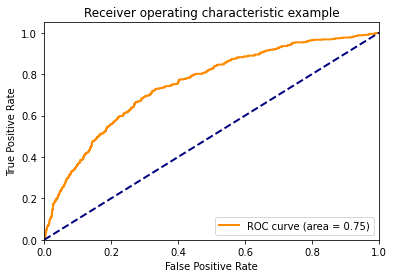

In [57]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [30]:
# BCE Loss
-sum(y_test["LStatus"]*np.log(predictions))/y_test.shape[0]

0.25137080145695895

In [31]:
ksscore = get_ksscore(predictions, y_test["LStatus"])[0]

In [32]:
# Classification Report
get_classification_report(predictions, y_test["LStatus"], ksscore)

     yhat = 0  yhat = 1
y=0      1837       880
y=1       157       402


### Neural Network Architecture

In [33]:
#from collections import OrderedDict

#loan_nn_model = nn.Sequential(OrderedDict([
#    ('hidden_linear', nn.Linear(7, 7)),
#    ('hidden_activation', nn.Tanh()),
#    ('output_linear', nn.Linear(7, 1)),
#]))

loan_nn_model = nn.Sequential(
    nn.Linear(26, 26),
    nn.Tanh(),
    nn.Linear(26, 1),
    nn.Sigmoid())

# Loss function without weight
loss_fn = nn.BCELoss() 

### The class is imbalanced.  May need to put weight
### weightval1 = 100-yvec_all.mean()*100
### weightval0 = yvec_all.mean()*100
### Not sure whether to put in weight1 or weight0
#loss_fn = nn.BCELoss(weight=weightval1) 

loan_nn_model

Sequential(
  (0): Linear(in_features=26, out_features=26, bias=True)
  (1): Tanh()
  (2): Linear(in_features=26, out_features=1, bias=True)
  (3): Sigmoid()
)

### Training Neural Network 

In [34]:
from sklearn.metrics import roc_curve, auc

def get_auc(y_hat_val, yvec_val):
    y_score = y_hat_val.detach().numpy()
    y_score = y_score.reshape((y_score.shape[0]))
    y_true = yvec_val.detach().numpy()
    y_true = y_true.reshape((y_true.shape[0]))
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    return auc_score

In [35]:
def training_loop(n_epochs, optimizer, model, loss_fn, xmat_train, xmat_val, yvec_train, yvec_val):
    for epoch in range(1, n_epochs + 1):
        yhat_train = model(xmat_train) # <1>
        train_loss = loss_fn(yhat_train, yvec_train)
        train_auc = get_auc(yhat_train, yvec_train)
                             
        with torch.no_grad():
            yhat_val = model(xmat_val) # <1>
            val_loss = loss_fn(yhat_val, yvec_val)
            val_auc = get_auc(yhat_val, yvec_val)
        
        optimizer.zero_grad()
        train_loss.backward() # <2>
        optimizer.step()
      
        if epoch == 1 or epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Training AUC {train_auc:.4f}", 
                  f" Validation loss {val_loss.item():.4f}, Validation AUC {val_auc:.4f}")

In [36]:
learning_rate = 1.5e-2
# optimizer = optim.SGD([params], lr=learning_rate)
optimizer = optim.Adam(loan_nn_model.parameters(), lr=learning_rate)
n_ep = 1000

training_loop(
    n_epochs = n_ep,
    optimizer = optimizer,
    model = loan_nn_model,
    loss_fn = loss_fn,
    xmat_train = xmat_train,
    xmat_val = xmat_val,
    yvec_train = yvec_train,
    yvec_val = yvec_val)

Epoch 1, Training loss 0.6155, Training AUC 0.5556  Validation loss 0.6177, Validation AUC 0.5457
Epoch 100, Training loss 0.4525, Training AUC 0.6603  Validation loss 0.4445, Validation AUC 0.6427
Epoch 200, Training loss 0.4255, Training AUC 0.6999  Validation loss 0.4216, Validation AUC 0.6862
Epoch 300, Training loss 0.4215, Training AUC 0.7106  Validation loss 0.4241, Validation AUC 0.6805
Epoch 400, Training loss 0.4187, Training AUC 0.7170  Validation loss 0.4275, Validation AUC 0.6777
Epoch 500, Training loss 0.4170, Training AUC 0.7195  Validation loss 0.4294, Validation AUC 0.6738
Epoch 600, Training loss 0.4160, Training AUC 0.7206  Validation loss 0.4307, Validation AUC 0.6728
Epoch 700, Training loss 0.4152, Training AUC 0.7216  Validation loss 0.4314, Validation AUC 0.6728
Epoch 800, Training loss 0.4145, Training AUC 0.7231  Validation loss 0.4321, Validation AUC 0.6723
Epoch 900, Training loss 0.4125, Training AUC 0.7262  Validation loss 0.4338, Validation AUC 0.6706
Ep

In [37]:
for name, param in loan_nn_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([26, 26])
0.bias torch.Size([26])
2.weight torch.Size([1, 26])
2.bias torch.Size([1])


### Shap

In [38]:
import shap
e = shap.DeepExplainer(loan_nn_model, data = xmat_test)

In [39]:
shap_values = np.zeros((xmat_test.shape[0], xmat_test.shape[1]))

for i in range(xmat_test.shape[0]):
    if i%100 == 0:
        print("Round ", i)
    shap_values[i, :] = e.shap_values(xmat_test[[i], :])

Round  0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Round  100
Round  200
Round  300
Round  400
Round  500
Round  600
Round  700
Round  800
Round  900
Round  1000
Round  1100
Round  1200
Round  1300
Round  1400
Round  1500
Round  1600
Round  1700
Round  1800
Round  1900
Round  2000
Round  2100
Round  2200
Round  2300
Round  2400
Round  2500
Round  2600
Round  2700
Round  2800
Round  2900
Round  3000
Round  3100
Round  3200


In [40]:
shap_values

array([[ 6.78613177e-03, -3.45435762e-03, -5.23457788e-02, ...,
        -1.39436126e-02, -3.85534950e-02, -1.83442459e-02],
       [ 1.30242620e-06, -3.28123715e-05,  6.37771636e-02, ...,
        -9.63195589e-07, -5.27258589e-06, -2.27112014e-06],
       [-1.11790057e-02, -5.90739818e-03,  2.43976377e-02, ...,
        -2.51798201e-02, -6.62859604e-02, -1.58838890e-02],
       ...,
       [ 1.02144701e-03,  4.39095125e-03, -5.07070534e-02, ...,
         5.53769816e-04, -2.73768138e-02, -2.13813838e-02],
       [-1.23392837e-02, -1.68806333e-02, -2.58719455e-02, ...,
         1.58756617e-02, -3.06041911e-02, -2.32490599e-02],
       [ 9.24045196e-07,  2.43283775e-05,  6.37393743e-02, ...,
        -2.18610921e-06,  3.36958547e-05, -5.15672491e-06]])

In [41]:
global_avg = torch.mean(yvec_train)
print(global_avg)

tensor(0.1763)


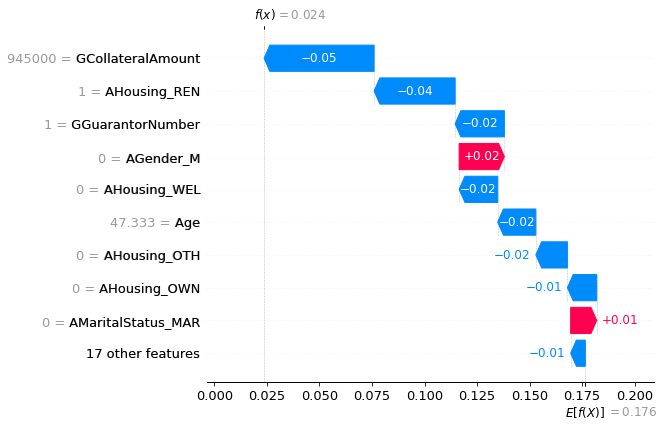

In [43]:
# https://github.com/slundberg/shap/issues/1420
class ShapInput(object):
    def __init__(self, expectation, shap_values, features, feat_names):
        self.base_values = expectation
        self.values = shap_values
        self.data = features
        self.feature_names = feat_names

shap_input = ShapInput(0.1765, shap_values[0], 
                       xmat_test[i, :], feat_names=editdummy.columns[1:])

shap.waterfall_plot(shap_input)

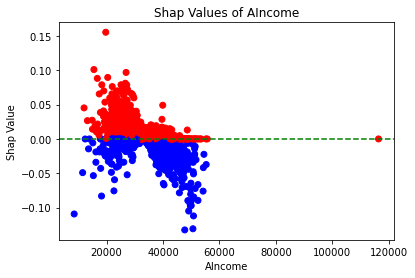

In [44]:
fig, ax = plt.subplots()
col_idx = 0
color = np.where(shap_values[:,col_idx] > 0, "red", "blue")
ax.scatter(X_test.iloc[:,col_idx],shap_values[:,col_idx], c = color)
x_col_name = X_test.columns[col_idx]
ax.set(xlabel = x_col_name, ylabel = "Shap Value", title = f"Shap Values of {x_col_name}")
ax.axhline(y = 0, color = 'green', linestyle = '--')

In [45]:
avg_shap = np.sum(abs(shap_values), axis = 0)/X_test.shape[0]
feature_importances = []
for i in range(X_test.shape[1]):
    f_importance = avg_shap[i]
    feature_name = X_test.columns[i]
    feature_importances.append((feature_name, f_importance))
    
feature_importances = sorted(feature_importances, key = lambda x: x[1])

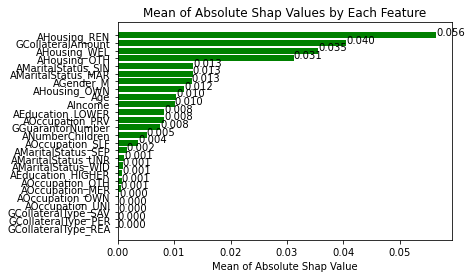

In [46]:
fig, ax = plt.subplots()

hbars = ax.barh([x[0] for x in feature_importances], [x[1] for x in feature_importances], color = "green")
ax.set(xlabel = "Mean of Absolute Shap Value", title = f"Mean of Absolute Shap Values by Each Feature")
                
for bar in hbars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    ax.text(width, label_y, s=f'{width:.3f}')